## Spark configuration

In [1]:
%%local
import os
import json

username = os.environ['JUPYTERHUB_USER']
namespace = os.environ['CI_NAMESPACE']
project = os.environ['CI_PROJECT']

configuration = dict(
    name = f"{username}-{namespace}-{project}",
    executorMemory = '4G',
    executorCores = 4,
    numExecutors = 10,
    driverMemory = "4G",
    conf = {
        # "spark.pyspark.python": "/opt/anaconda3/bin/python3", # Use python3
        "spark.jars.repositories": "https://repos.spark-packages.org",
        "spark.jars.packages": "graphframes:graphframes:0.7.0-spark2.3-s_2.11"
    }
)
# set the application name as "<your_gaspar_id>-homework3"
get_ipython().run_cell_magic('configure', line="-f", cell=json.dumps(configuration))


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
7218,application_1618324153128_6949,pyspark,idle,Link,Link,None,


## Creating Spark connection

In [2]:
sc.addPyFile('graphframes_graphframes-0.7.0-spark2.3-s_2.11.jar')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
7230,application_1618324153128_6961,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%%send_to_spark -i username -t str -n username

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Successfully passed 'username' as 'username' to Spark kernel

In [4]:
username

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'benhaj'

## Import cleaned stop stations data

In [5]:
def clean_stops(df_stops):
    df_stops = df_stops.na.drop()
    df_stops = df_stops.select(
                df_stops.stop_id,
                df_stops.stop_name,
                df_stops.stop_lat.cast("float"),
                df_stops.stop_lon.cast("float"))
    return df_stops

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
GEOSTOPS_PATH = "/data/sbb/orc/geostops"
df_stops = spark.read.orc(GEOSTOPS_PATH)
df_stops = clean_stops(df_stops)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col
from math import radians, cos, sin, asin, sqrt
#Computes distance to Zurich HB
RADIUS = 6371.0
@F.udf
def distanceToZurichHB(lat,lon):
    lat=radians(lat)
    lon=radians(lon)
    zurich_lat = radians(47.378177)
    zurich_lon = radians(8.540192)
    a= sin((zurich_lat-lat)/2)**2 + cos(lat) * cos(zurich_lat) * sin((zurich_lon-lon)/2)**2
    c= 2*asin(sqrt(a))
    return RADIUS*c 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Filter all stops that are not in the 15km radius reachable from Zürich HB

In [8]:
# Finds stops reachable at 15km from Zurich HB
def reachableStops(dfStops):
    reachable_stops = df_stops.withColumn('distance_to_Zurich', distanceToZurichHB(df_stops.stop_lat, df_stops.stop_lon))\
                        .filter(F.col('distance_to_Zurich') <= 15.0)\
                        .select('stop_id','stop_lat','stop_lon','stop_name')
    #cleaning the stop_id
    reachable_stops = reachable_stops.withColumn('stop_id', col('stop_id').substr(0, 7))
    return reachable_stops

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:
df_stops_zurich = reachableStops(df_stops)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [10]:
#Compute distance between two stops
@F.udf
def distance(lat1,lon1,lat2,lon2):
    lat1=radians(lat1)
    lon1=radians(lon1)
    lat2=radians(lat2)
    lon2=radians(lon2)
    a= sin((lat1-lat2)/2)**2 + cos(lat1) * cos(lat2) * sin((lon1-lon2)/2)**2
    c= 2*asin(sqrt(a))
    return RADIUS*c
    

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [11]:
# Create dataframe with distance beween all stops.
def distance_pairs(stops):
    stops_from = stops.withColumnRenamed('stop_id', 'from_stopID')\
                      .withColumnRenamed('stop_lon', 'from_Longitude')\
                      .withColumnRenamed('stop_lat', 'from_Latitude')\
                      .withColumnRenamed('stop_name', 'from_stop_name')\
    
    stops_to = stops.withColumnRenamed('stop_id', 'to_stopID')\
                    .withColumnRenamed('stop_lon', 'to_Longitude')\
                    .withColumnRenamed('stop_lat', 'to_Latitude')\
                    .withColumnRenamed('stop_name', 'to_stop_name')\
                
    stops_pairs_dist = stops_from.crossJoin(stops_to)
    stops_pairs_dist = stops_pairs_dist.filter(stops_pairs_dist.from_stopID != stops_pairs_dist.to_stopID)
    stops_pairs_dist = stops_pairs_dist.withColumn('distance', distance(stops_pairs_dist.from_Latitude, stops_pairs_dist.from_Longitude,
                                                                                stops_pairs_dist.to_Latitude, stops_pairs_dist.to_Longitude))
    return stops_pairs_dist

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Dataframe with distance beween all stops

In [12]:
stops_distance_pairs= distance_pairs(df_stops_zurich)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Filtering pairs of stations which are distant by less than the walking distance (500m) and compute necessary time to walk from one to another

In [13]:
#Takes all pairs of stops with their distance & returns pairs of distance that are reachable by walk
#with the walking time
WALKING_DISTANCE = 0.5
def reachable_stops_by_walk(stops_distance_pairs):
    walking_stations_pairs= stops_distance_pairs.where(stops_distance_pairs.distance <= WALKING_DISTANCE)
    walking_stations_pairs = walking_stations_pairs.withColumn('walking_time_sec', (60*walking_stations_pairs.distance / 0.05).astype('int')+1)
    return walking_stations_pairs

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
walking_stations_pairs= reachable_stops_by_walk(stops_distance_pairs)
walking_stations_pairs.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------------+--------------+-------------------+---------+-----------+------------+--------------------+--------------------+----------------+
|from_stopID|from_Latitude|from_Longitude|     from_stop_name|to_stopID|to_Latitude|to_Longitude|        to_stop_name|            distance|walking_time_sec|
+-----------+-------------+--------------+-------------------+---------+-----------+------------+--------------------+--------------------+----------------+
|    8503204|    47.261486|      8.596904|             Horgen|  8503855|  47.261612|    8.595674|     Horgen, Bahnhof|  0.0938866145602827|             113|
|    8502273|     47.35147|      8.346553|         Bremgarten|  8517377|   47.35379|    8.350272|  Bibenlos-Sonnenhof|  0.3808105418685621|             457|
|    8503016|    47.450382|      8.562382|   Zürich Flughafen|  8573205|   47.45016|    8.563747|Zürich Flughafen,...| 0.10559461754703091|             127|
|    8502188|    47.355835|      8.354728|  Zufikon Hammer

## Importing stop times of 2019/05/07

In [15]:
STOP_TIMES_PATH = '/data/sbb/csv/timetable/stop_times/2019/05/07/stop_times.csv'
df_stops_times=spark.read.csv(STOP_TIMES_PATH, header=True)
df_stops_times = df_stops_times.select('trip_id','arrival_time','departure_time','stop_id','stop_sequence')
df_stops_times = df_stops_times.withColumn('stop_id', F.col('stop_id').substr(0, 7))
df_stops_times.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+------------+--------------+-------+-------------+
|            trip_id|arrival_time|departure_time|stop_id|stop_sequence|
+-------------------+------------+--------------+-------+-------------+
|1.TA.1-84-j19-1.1.H|    06:13:00|      06:13:00|8572249|            1|
|1.TA.1-84-j19-1.1.H|    06:14:00|      06:14:00|8577508|            2|
|1.TA.1-84-j19-1.1.H|    06:15:00|      06:15:00|8581070|            3|
|1.TA.1-84-j19-1.1.H|    06:16:00|      06:16:00|8578360|            4|
|1.TA.1-84-j19-1.1.H|    06:17:00|      06:17:00|8583448|            5|
|1.TA.1-84-j19-1.1.H|    06:18:00|      06:19:00|8578359|            6|
|1.TA.1-84-j19-1.1.H|    06:24:00|      06:24:00|8578358|            7|
|1.TA.1-84-j19-1.1.H|    06:25:00|      06:25:00|8582802|            8|
|1.TA.1-84-j19-1.1.H|    06:27:00|      06:27:00|8578348|            9|
|1.TA.1-84-j19-1.1.H|    06:43:00|      06:43:00|8594994|           10|
+-------------------+------------+--------------+-------+-------

## Joining stop times with stop stations informations

In [16]:
df_stops_times_zurich=df_stops_times.join(df_stops_zurich, df_stops_times.stop_id == df_stops_zurich.stop_id).drop(df_stops_times.stop_id)
df_stops_times_zurich.printSchema()
df_stops_times_zurich.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- trip_id: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- stop_sequence: string (nullable = true)
 |-- stop_id: string (nullable = true)
 |-- stop_lat: float (nullable = true)
 |-- stop_lon: float (nullable = true)
 |-- stop_name: string (nullable = true)

+--------------------+------------+--------------+-------------+-------+---------+--------+--------------------+
|             trip_id|arrival_time|departure_time|stop_sequence|stop_id| stop_lat|stop_lon|           stop_name|
+--------------------+------------+--------------+-------------+-------+---------+--------+--------------------+
|1.TA.1-N31-j19-1.1.R|    25:25:00|      25:25:00|            1|8587020|47.405834|8.404521|   Dietikon, Bahnhof|
|2.TA.1-N31-j19-1.1.R|    26:25:00|      26:25:00|            1|8587020|47.405834|8.404521|   Dietikon, Bahnhof|
|3.TA.1-N31-j19-1.1.R|    27:25:00|      27:25:00|            1|8587020|47.405834|8.404521|   Die

In [17]:
n_stops = df_stops_times_zurich.select('stop_id').distinct().count()
print('The number of considered stops is '+ str(n_stops))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The number of considered stops is 77

## Cleaning data by time
We will ommit the stops where arrival/departure time >=25:00:00
##### We only consider journeys at reasonable hours of the day, and on a typical business day, and assuming the schedule of May 13-17, 2019.
Reasonable hours of the day:
from 7:00 to 19:00 

In [18]:
#Cleaning data by time assumptions
def clean_data_by_time(df_stops_times_zurich):
    return df_stops_times_zurich.filter(F.split(df_stops_times_zurich.arrival_time, ':')[0]< 19)\
                                            .filter(F.split(df_stops_times_zurich.arrival_time, ':')[0] > 6)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
df_stops_times_zurich = clean_data_by_time(df_stops_times_zurich)
df_stops_times_zurich.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+--------------+-------------+-------+---------+--------+---------+
|             trip_id|arrival_time|departure_time|stop_sequence|stop_id| stop_lat|stop_lon|stop_name|
+--------------------+------------+--------------+-------------+-------+---------+--------+---------+
|442.TA.1-16-j19-1...|    16:54:00|      16:54:00|            5|8503000|47.378178|8.540194|Zürich HB|
|464.TA.1-16-j19-1...|    18:54:00|      18:54:00|            5|8503000|47.378178|8.540194|Zürich HB|
|363.TA.1-16-j19-1...|    07:54:00|      07:54:00|            5|8503000|47.378178|8.540194|Zürich HB|
|417.TA.1-16-j19-1...|    13:54:00|      13:54:00|            5|8503000|47.378178|8.540194|Zürich HB|
|465.TA.1-16-j19-1...|    18:54:00|      18:54:00|            5|8503000|47.378178|8.540194|Zürich HB|
|375.TA.1-16-j19-1...|    08:54:00|      08:54:00|            5|8503000|47.378178|8.540194|Zürich HB|
|408.TA.1-16-j19-1...|    12:54:00|      12:54:00|            5|8503000|47.378178|

## Create Dataframe : From_stop_id, To_stop_id, departure_time, arrival_time, duration 

In [20]:
stops_times_from = df_stops_times_zurich.withColumnRenamed('arrival_time', 'from_arrival_time')\
                      .withColumnRenamed('departure_time', 'from_departure_time')\
                      .withColumnRenamed('stop_id', 'from_stop_id')\
                      .withColumnRenamed('stop_name', 'from_stop_name')\
                    .withColumnRenamed('stop_sequence','from_stop_sequence').drop('stop_lat').drop("stop_lon")
                
stops_times_to = df_stops_times_zurich.withColumnRenamed('arrival_time', 'to_arrival_time')\
                      .withColumnRenamed('departure_time', 'to_departure_time')\
                      .withColumnRenamed('stop_id', 'to_stop_id')\
                     .withColumnRenamed('stop_name', 'to_stop_name')\
                    .withColumnRenamed('stop_sequence','to_stop_sequence')\
                    .withColumnRenamed('trip_id','trip_id_2').drop('stop_lat').drop("stop_lon")
                
stops_from_to = stops_times_from.join(stops_times_to,stops_times_from.trip_id == stops_times_to.trip_id_2)

stops_from_to = stops_from_to.filter(stops_from_to.from_stop_sequence == stops_from_to.to_stop_sequence-1).drop(stops_from_to.trip_id_2)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

##### Here we drop the departure times from our stops_from_to dataframe. Since our final goal is to present to the user reliable paths, that enables his to arrive to a specific stop at a specific time. And since a majority of these departure times are the same as the arrival time (a maximum of 1mn difference), we can just use the arrival time at each stop.

In [21]:
stops_from_to=stops_from_to.drop("from_departure_time").drop('to_departure_time')
stops_from_to.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+------------------+------------+--------------------+---------------+----------------+----------+--------------------+
|             trip_id|from_arrival_time|from_stop_sequence|from_stop_id|      from_stop_name|to_arrival_time|to_stop_sequence|to_stop_id|        to_stop_name|
+--------------------+-----------------+------------------+------------+--------------------+---------------+----------------+----------+--------------------+
|1151.TA.26-759-j1...|         10:01:00|                 1|     8573205|Zürich Flughafen,...|       10:02:00|               2|   8573213|Zürich Flughafen,...|
|1237.TA.26-759-j1...|         16:58:00|                 1|     8573205|Zürich Flughafen,...|       16:59:00|               2|   8573213|Zürich Flughafen,...|
|132.TA.26-759-j19...|         08:31:00|                 1|     8573205|Zürich Flughafen,...|       08:32:00|               2|   8573213|Zürich Flughafen,...|
|15.TA.63-10-Y-j19...|         16:49:00|      

### These are the assumptions that we have already implemented : 

- We allow short (total max 500m "As the Crows Flies") walking distances for transfers between two stops, and assume a walking speed of 50m/1min on a straight line, regardless of obstacles, human-built or natural, such as building, highways, rivers, or lakes.

- We only consider journeys that start and end on known station coordinates (train station, bus stops, etc.), never from a random location. However, walking from the departure stop to a nearby stop is allowed.

- We only consider departure and arrival stops in a 15km radius of Zürich's train station, Zürich HB (8503000), (lat, lon) = (47.378177, 8.540192).

- We only consider stops in the 15km radius that are reachable from Zürich HB. If needed stops may be reached via transfers through other stops outside the 15km area.

- We only consider journeys at reasonable hours of the day, and on a typical business day, and assuming the schedule of May 13-17, 2019.

### upload trips.txt

In [22]:
TRIPS_PATH = '/data/sbb/csv/timetable/trips/2019/05/07/trips.csv'
df_trips=spark.read.csv(TRIPS_PATH, header=True)
df_trips = df_trips.select('trip_id','direction_id','route_id')
df_trips.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------+-----------+
|             trip_id|direction_id|   route_id|
+--------------------+------------+-----------+
| 2.TA.1-85-j19-1.1.H|           0| 1-85-j19-1|
|5.TA.1-1-C-j19-1.3.R|           1|1-1-C-j19-1|
|7.TA.1-1-C-j19-1.3.R|           1|1-1-C-j19-1|
|9.TA.1-1-C-j19-1.3.R|           1|1-1-C-j19-1|
|11.TA.1-1-C-j19-1...|           1|1-1-C-j19-1|
|13.TA.1-1-C-j19-1...|           1|1-1-C-j19-1|
|15.TA.1-1-C-j19-1...|           1|1-1-C-j19-1|
|17.TA.1-1-C-j19-1...|           1|1-1-C-j19-1|
|18.TA.1-1-C-j19-1...|           1|1-1-C-j19-1|
|19.TA.1-1-C-j19-1...|           1|1-1-C-j19-1|
|20.TA.1-1-C-j19-1...|           1|1-1-C-j19-1|
|21.TA.1-1-C-j19-1...|           1|1-1-C-j19-1|
|22.TA.1-1-C-j19-1...|           1|1-1-C-j19-1|
|23.TA.1-1-C-j19-1...|           1|1-1-C-j19-1|
|24.TA.1-1-C-j19-1...|           1|1-1-C-j19-1|
|25.TA.1-1-C-j19-1...|           1|1-1-C-j19-1|
|26.TA.1-1-C-j19-1...|           1|1-1-C-j19-1|
|27.TA.1-1-C-j19-1...|           1|1-1-C

In [23]:
## here we add the direction attribute to our stops_from_to dataframe
df_from_to = stops_from_to.join(df_trips,'trip_id','inner').drop('from_stop_sequence','to_stop_sequence')
df_from_to.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----------------+------------+--------------------+---------------+----------+--------------------+------------+------------+
|             trip_id|from_arrival_time|from_stop_id|      from_stop_name|to_arrival_time|to_stop_id|        to_stop_name|direction_id|    route_id|
+--------------------+-----------------+------------+--------------------+---------------+----------+--------------------+------------+------------+
|100.TA.26-11-j19-...|         14:00:00|     8503000|           Zürich HB|       14:04:00|   8503003|  Zürich Stadelhofen|           0| 26-11-j19-1|
|100.TA.26-11-j19-...|         13:53:00|     8503001|   Zürich Altstetten|       13:56:00|   8503020|   Zürich Hardbrücke|           0| 26-11-j19-1|
|100.TA.26-11-j19-...|         13:49:00|     8503509|           Schlieren|       13:53:00|   8503001|   Zürich Altstetten|           0| 26-11-j19-1|
|100.TA.26-11-j19-...|         14:04:00|     8503003|  Zürich Stadelhofen|       14:09:00|   8503147|     

In [24]:
walking_stations_pairs = walking_stations_pairs.drop("from_Latitude","from_Longitude","to_Latitude","to_Longitude",'distance')
walking_stations_pairs.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+-------------------+---------+--------------------+----------------+
|from_stopID|     from_stop_name|to_stopID|        to_stop_name|walking_time_sec|
+-----------+-------------------+---------+--------------------+----------------+
|    8503204|             Horgen|  8503855|     Horgen, Bahnhof|             113|
|    8502273|         Bremgarten|  8517377|  Bibenlos-Sonnenhof|             457|
|    8503016|   Zürich Flughafen|  8573205|Zürich Flughafen,...|             127|
|    8502188|  Zufikon Hammergut|  8517377|  Bibenlos-Sonnenhof|             487|
|    8503127|   Schwerzenbach ZH|  8576127|Schwerzenbach ZH,...|              97|
|    8502222|Bonstetten-Wettswil|  8573726|Bonstetten-Wettsw...|              61|
|    8503305|         Effretikon|  8575918| Effretikon, Bahnhof|             101|
|    8503310|         Glattbrugg|  8503340|             Opfikon|             290|
|    8575918|Effretikon, Bahnhof|  8503305|          Effretikon|             101|
|    8587020|  D

### Load ISTDATEN data (the actual data, that will be used to compute a probabilistic estimation of the delay)

In [25]:
ISTDATEN_PATH = '/data/sbb/csv/istdaten/2019/05/2019-05-07_istdaten.csv'
df_trajets=spark.read.option("delimiter", ";").csv(ISTDATEN_PATH, header=True)
df_trajets = df_trajets.select('BETRIEBSTAG','HALTESTELLEN_NAME',"PRODUKT_ID",'ANKUNFTSZEIT','ABFAHRTSZEIT',"AN_PROGNOSE","AN_PROGNOSE_STATUS","AB_PROGNOSE","AB_PROGNOSE_STATUS")\
                    .withColumnRenamed("BETRIEBSTAG","date") \
                    .withColumnRenamed("HALTESTELLEN_NAME","stop_name") \
                    .withColumnRenamed("ANKUNFTSZEIT","arrival_time") \
                    .withColumnRenamed("ABFAHRTSZEIT","departure_time") \
                    .withColumnRenamed("AN_PROGNOSE","actual_arrival_time") \
                    .withColumnRenamed("AN_PROGNOSE_STATUS","arrival_status") \
                    .withColumnRenamed("AB_PROGNOSE","actual_departure_time") \
                    .withColumnRenamed("AB_PROGNOSE_STATUS","departure_status") \
                    .withColumnRenamed("PRODUKT_ID",'type') \

df_trajets.printSchema()
df_trajets.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- date: string (nullable = true)
 |-- stop_name: string (nullable = true)
 |-- type: string (nullable = true)
 |-- arrival_time: string (nullable = true)
 |-- departure_time: string (nullable = true)
 |-- actual_arrival_time: string (nullable = true)
 |-- arrival_status: string (nullable = true)
 |-- actual_departure_time: string (nullable = true)
 |-- departure_status: string (nullable = true)

+----------+------------+----+----------------+----------------+-------------------+--------------+---------------------+----------------+
|      date|   stop_name|type|    arrival_time|  departure_time|actual_arrival_time|arrival_status|actual_departure_time|departure_status|
+----------+------------+----+----------------+----------------+-------------------+--------------+---------------------+----------------+
|07.05.2019|Basel Bad Bf| Zug|            null|07.05.2019 05:42|               null|      PROGNOSE|                 null|       UNBEKANNT|
|07.05.2019|Basel Bad Bf| Zug|       

In [26]:
df_trajets = df_trajets.withColumn('type', F.lower(F.col('type'))).dropna(subset='type').filter(F.col('type')!='schiff')
df_trajets.filter('arrival_status == "GESCHAETZT"').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+--------------------+----+----------------+----------------+-------------------+--------------+---------------------+----------------+
|      date|           stop_name|type|    arrival_time|  departure_time|actual_arrival_time|arrival_status|actual_departure_time|departure_status|
+----------+--------------------+----+----------------+----------------+-------------------+--------------+---------------------+----------------+
|07.05.2019|   Lausanne, Bel-Air| bus|07.05.2019 18:42|07.05.2019 18:42|07.05.2019 18:41:42|    GESCHAETZT|  07.05.2019 18:42:14|      GESCHAETZT|
|07.05.2019| Lausanne, Chauderon| bus|07.05.2019 18:44|07.05.2019 18:44|07.05.2019 18:42:54|    GESCHAETZT|  07.05.2019 18:43:54|      GESCHAETZT|
|07.05.2019|    Lausanne, Boston| bus|07.05.2019 18:45|07.05.2019 18:44|07.05.2019 18:44:35|    GESCHAETZT|  07.05.2019 18:44:35|      GESCHAETZT|
|07.05.2019|  Lausanne, Recordon| bus|07.05.2019 18:47|07.05.2019 18:46|07.05.2019 18:45:40|    GESCHAETZT|  07.05.201

In [27]:
df_stops_zurich = df_stops_zurich.withColumnRenamed('stop_name','stop_name2')
df_trajets_zurich = df_trajets.join(df_stops_zurich).filter(df_trajets.stop_name.isin(df_stops_zurich.stop_name2)).drop('stop_lat').drop('stop_lon').drop('date').drop("stop_name2")
df_trajets_zurich.show(30)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----+----------------+----------------+-------------------+--------------+---------------------+----------------+-------+
|       stop_name|type|    arrival_time|  departure_time|actual_arrival_time|arrival_status|actual_departure_time|departure_status|stop_id|
+----------------+----+----------------+----------------+-------------------+--------------+---------------------+----------------+-------+
|       Zürich HB| zug|07.05.2019 21:50|            null|               null|      PROGNOSE|                 null|        PROGNOSE|8503000|
|       Zürich HB| zug|07.05.2019 06:23|            null|07.05.2019 06:22:32|          REAL|                 null|        PROGNOSE|8503000|
|       Zürich HB| zug|07.05.2019 07:23|            null|07.05.2019 07:27:45|          REAL|                 null|        PROGNOSE|8503000|
|       Zürich HB| zug|07.05.2019 08:23|            null|07.05.2019 08:23:22|          REAL|                 null|        PROGNOSE|8503000|
|Zürich Flughafen| z

In [28]:
stop_id_type = df_trajets_zurich.select("stop_id",'type')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

#### We found out that, for all the stops that we consider (in a 15km perimeter) , there is only two stops where the type of transport is not unique (can be train or bus) these stops are 8573205 and 8502273. we will try and figure which trips corresponds to which type of transport

In [29]:
df_from_to.where('from_stop_id==8573205').select('from_stop_name').distinct().collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(from_stop_name=u'Z\xfcrich Flughafen, Bahnhof')]

In [30]:
df_from_to.where('from_stop_id==8573205').select('to_stop_name').distinct().collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(to_stop_name=u'Z\xfcrich Flughafen, Werft')]

##### We found on SBB that this trip from "Zurich Flughafen, Bahnhof" to "Zurich Flughafen, Werft" is always on BUS

In [31]:
df_from_to.where('from_stop_id==8502273').select('from_stop_name').distinct().collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(from_stop_name=u'Bremgarten')]

In [32]:
df_from_to.where('from_stop_id==8502273').select('to_stop_name').distinct().collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(to_stop_name=u'Berikon-Widen'), Row(to_stop_name=u'Bibenlos-Sonnenhof')]

##### We found on SBB that this trip from "Bremgarten" to "Berikon-Widen" is always on TRAIN

In [33]:
stop_id_type = stop_id_type.withColumn('type',F.when(stop_id_type.type=='zug','train').otherwise(stop_id_type.type))
stop_id_type = stop_id_type.withColumn('type_2',F.when(stop_id_type.stop_id=='8502273','train').otherwise(stop_id_type.type))
stop_id_type = stop_id_type.withColumn('type',F.when(stop_id_type.stop_id=='8573205','bus').otherwise(stop_id_type.type_2)).drop('type_2')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Create a final dataframe to be fed to our routing algorithm with columns :

#### from | to | departure_time | arrival_time | trip_id | type | duration(for walking) | direction | route_id

In [34]:
stop_id_type = stop_id_type.withColumnRenamed("stop_id",'from_stop_id')

df_from_to = df_from_to.join(stop_id_type.distinct(),'from_stop_id','inner')

## replace zug with train
df_from_to=df_from_to.withColumn('type',F.when(F.col('type')=="zug",'train').otherwise(F.col('type')))

df_from_to.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+--------------------+-----------------+--------------+---------------+----------+------------+------------+-----------+-----+
|from_stop_id|             trip_id|from_arrival_time|from_stop_name|to_arrival_time|to_stop_id|to_stop_name|direction_id|   route_id| type|
+------------+--------------------+-----------------+--------------+---------------+----------+------------+------------+-----------+-----+
|     8503303|144.TA.26-3-j19-1...|         17:02:00|        Illnau|       17:08:00|   8503305|  Effretikon|           0| 26-3-j19-1|train|
|     8503303|101.TA.26-3-j19-1...|         09:32:00|        Illnau|       09:38:00|   8503305|  Effretikon|           0| 26-3-j19-1|train|
|     8503303| 9.TA.26-3-j19-1.5.H|         17:02:00|        Illnau|       17:08:00|   8503305|  Effretikon|           0| 26-3-j19-1|train|
|     8503303|21.TA.26-19-j19-1...|         18:13:00|        Illnau|       18:20:00|   8503305|  Effretikon|           1|26-19-j19-1|train|
|     8503303|49.TA.

In [35]:
final_df = df_from_to.withColumnRenamed('from_stop_id','source')\
                     .withColumnRenamed('to_stop_id','target')\
                     .withColumnRenamed('from_arrival_time','departure')\
                     .withColumnRenamed('to_arrival_time','arrival')\
                     .withColumnRenamed('from_stop_id','from')

## Prepare walking dataframe to add to our final df
walking_df = walking_stations_pairs.withColumnRenamed('from_stopID','source').withColumnRenamed('to_stopID','target')\
                                .withColumnRenamed('walking_time_sec','walk_duration').withColumn('type',F.lit('walking'))
walking_df = walking_df.withColumn('trip_id',F.lit(None)).withColumn('departure',F.lit(None)).withColumn('arrival',F.lit(None)).withColumn('direction_id',F.lit(None)).withColumn('route_id',F.lit(None))


# add walking edges to our dataframe
final_df= final_df.withColumn('walk_duration',F.lit(None)).unionByName(walking_df)

final_df.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+---------+--------------+--------+-------+------------+------------+----------+-----+-------------+
| source|             trip_id|departure|from_stop_name| arrival| target|to_stop_name|direction_id|  route_id| type|walk_duration|
+-------+--------------------+---------+--------------+--------+-------+------------+------------+----------+-----+-------------+
|8503303|103.TA.26-3-j19-1...| 10:02:00|        Illnau|10:08:00|8503305|  Effretikon|           0|26-3-j19-1|train|         null|
|8503303|106.TA.26-3-j19-1...| 11:02:00|        Illnau|11:08:00|8503305|  Effretikon|           0|26-3-j19-1|train|         null|
|8503303|139.TA.26-3-j19-1...| 13:02:00|        Illnau|13:08:00|8503305|  Effretikon|           0|26-3-j19-1|train|         null|
|8503303|128.TA.26-3-j19-1...| 12:02:00|        Illnau|12:08:00|8503305|  Effretikon|           0|26-3-j19-1|train|         null|
|8503303|31.TA.26-3-j19-1.6.H| 11:32:00|        Illnau|11:38:00|8503305|  Effretikon|     

In [36]:
walking_df.show() ##  8503006 --> 8503340 --> 8503310 --> 8503311

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+-------+--------------------+-------------+-------+-------+---------+-------+------------+--------+
| source|      from_stop_name| target|        to_stop_name|walk_duration|   type|trip_id|departure|arrival|direction_id|route_id|
+-------+--------------------+-------+--------------------+-------------+-------+-------+---------+-------+------------+--------+
|8503204|              Horgen|8503855|     Horgen, Bahnhof|          113|walking|   null|     null|   null|        null|    null|
|8502273|          Bremgarten|8517377|  Bibenlos-Sonnenhof|          457|walking|   null|     null|   null|        null|    null|
|8503016|    Zürich Flughafen|8573205|Zürich Flughafen,...|          127|walking|   null|     null|   null|        null|    null|
|8502188|   Zufikon Hammergut|8517377|  Bibenlos-Sonnenhof|          487|walking|   null|     null|   null|        null|    null|
|8503127|    Schwerzenbach ZH|8576127|Schwerzenbach ZH,...|           97|walking|   null| 

In [37]:
df_from_to.where('to_stop_id=8503340').show(100)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+--------------------+-----------------+---------------+---------------+----------+------------+------------+------------+-----+
|from_stop_id|             trip_id|from_arrival_time| from_stop_name|to_arrival_time|to_stop_id|to_stop_name|direction_id|    route_id| type|
+------------+--------------------+-----------------+---------------+---------------+----------+------------+------------+------------+-----+
|     8503006|352.TA.26-7-A-j19...|         16:26:00|Zürich Oerlikon|       16:30:00|   8503340|     Opfikon|           0|26-7-A-j19-1|train|
|     8503006|526.TA.26-7-A-j19...|         17:26:00|Zürich Oerlikon|       17:30:00|   8503340|     Opfikon|           0|26-7-A-j19-1|train|
|     8503006|351.TA.26-7-A-j19...|         16:26:00|Zürich Oerlikon|       16:30:00|   8503340|     Opfikon|           0|26-7-A-j19-1|train|
|     8503006|355.TA.26-7-A-j19...|         16:56:00|Zürich Oerlikon|       17:00:00|   8503340|     Opfikon|           0|26-7-A-j19-1|train|
|     

In [38]:
final_df.filter("departure='none'").show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-------+---------+--------------+-------+------+------------+------------+--------+----+-------------+
|source|trip_id|departure|from_stop_name|arrival|target|to_stop_name|direction_id|route_id|type|walk_duration|
+------+-------+---------+--------------+-------+------+------------+------------+--------+----+-------------+
+------+-------+---------+--------------+-------+------+------------+------------+--------+----+-------------+

In [39]:
#changing name of final_df
final_df_prime = final_df

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
final_df.select('type').distinct().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+
|   type|
+-------+
|    bus|
|  train|
|walking|
+-------+

## Dealing with delays

In [41]:
df_trajets_zurich.select('arrival_status').distinct().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+
|arrival_status|
+--------------+
|      PROGNOSE|
|          REAL|
|     UNBEKANNT|
+--------------+

In [42]:
df_trajets_zurich.select('departure_status').distinct().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+
|departure_status|
+----------------+
|        PROGNOSE|
|       UNBEKANNT|
|            REAL|
+----------------+

Now we will ommit the ones where arrival and departure status are unknown (UNBEKANNT)

In [43]:
df_trajets_zurich=df_trajets_zurich.filter("departure_status!='UNBEKANNT'").filter("arrival_status!='UNBEKANNT'")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [44]:
df_trajets_zurich.select('stop_name').distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

74

In [45]:
df_stops_zurich.select('stop_name2').distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

77

There is only 3 stops that are in our Zurich AREA but not in istdaten (those two stops will be considered as NOT HAVING ANY DELAYS)

Now we will calculate the delay for each trip in our istdaten zurich trips (df_trajets_zurich)

In [46]:
df_trajets_zurich = df_trajets_zurich.withColumn('arrival_time',F.unix_timestamp('arrival_time',format='dd.MM.yyyy HH:mm'))
df_trajets_zurich = df_trajets_zurich.withColumn('departure_time',F.unix_timestamp('departure_time',format='dd.MM.yyyy HH:mm'))
df_trajets_zurich = df_trajets_zurich.withColumn('actual_departure_time',F.unix_timestamp('actual_departure_time',format='dd.MM.yyyy HH:mm:ss'))
df_trajets_zurich = df_trajets_zurich.withColumn('actual_arrival_time',F.unix_timestamp('actual_arrival_time',format='dd.MM.yyyy HH:mm:ss'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
df_trajets_zurich = df_trajets_zurich.withColumn('arrival_delay', df_trajets_zurich['actual_arrival_time'] - df_trajets_zurich['arrival_time'] )
df_trajets_zurich = df_trajets_zurich.withColumn('departure_delay', df_trajets_zurich['actual_departure_time'] - df_trajets_zurich['departure_time'] )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [48]:
df_trajets_zurich = df_trajets_zurich.withColumn('departure_delay',F.when(df_trajets_zurich.departure_delay.isNull(),0).otherwise(df_trajets_zurich.departure_delay))
df_trajets_zurich = df_trajets_zurich.withColumn('arrival_delay',F.when(df_trajets_zurich.arrival_delay.isNull(),0).otherwise(df_trajets_zurich.arrival_delay))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

##### Now, we have two different delays : one for arrival times and one for departure times. Here, since the arrival time definitely affects the departure time, and in many cases where the train/bus is having a delay, the departure time is accelerated to catch up the delay. So Here we assume that the overral delay of each stop is the mean between these two delays. (arrival_delay+departure_delay)/2

In [49]:
df_trajets_zurich=df_trajets_zurich.withColumn('delay',(df_trajets_zurich.arrival_delay + df_trajets_zurich.departure_delay)/2).drop('arrival_delay').drop('departure_delay')

df_trajets_zurich = df_trajets_zurich.withColumn('arrival_time',F.from_unixtime('arrival_time',format='dd.MM.yyyy HH:mm')) \
                                     .withColumn('departure_time',F.from_unixtime('departure_time',format='dd.MM.yyyy HH:mm')) \
                                    .drop('actual_arrival_time').drop('arrival_status') \
                                    .drop('actual_departure_time').drop('departure_status')
df_trajets_zurich.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+----+----------------+----------------+-------+-----+
|       stop_name|type|    arrival_time|  departure_time|stop_id|delay|
+----------------+----+----------------+----------------+-------+-----+
|       Zürich HB| zug|07.05.2019 21:50|            null|8503000|  0.0|
|       Zürich HB| zug|07.05.2019 06:23|            null|8503000|-14.0|
|       Zürich HB| zug|07.05.2019 07:23|            null|8503000|142.5|
|       Zürich HB| zug|07.05.2019 08:23|            null|8503000| 11.0|
|Zürich Flughafen| zug|07.05.2019 22:46|07.05.2019 22:48|8503016|337.5|
|       Zürich HB| zug|07.05.2019 22:58|07.05.2019 23:08|8503000|317.0|
|       Zürich HB| zug|            null|07.05.2019 06:10|8503000| 49.0|
|       Zürich HB| zug|07.05.2019 10:50|            null|8503000| 22.5|
|       Zürich HB| zug|07.05.2019 07:00|            null|8503000| 24.0|
|       Zürich HB| zug|07.05.2019 21:23|07.05.2019 21:36|8503000|  2.0|
|       Zürich HB| zug|07.05.2019 08:26|07.05.2019 08:37|8503000

In [50]:
%%spark -o df_trajets_zurich -n -1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<AxesSubplot:ylabel='Density'>

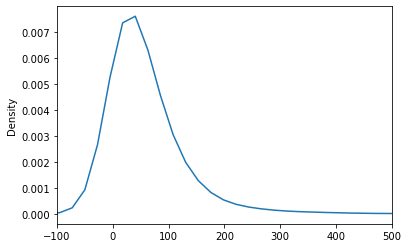

In [51]:
%%local
df_trajets_zurich['delay'].plot(kind='density',x='delay',xlim=[-100,500])

#### we will assume that the negative delay values are not taken into account since our goal is to ensure thate each relation/change is achieved with a certain probability of succes, so considering that negative delays as zero delays will make our model more robust and more sure. Let's see the result when we consider only positive delays:


<AxesSubplot:ylabel='Density'>

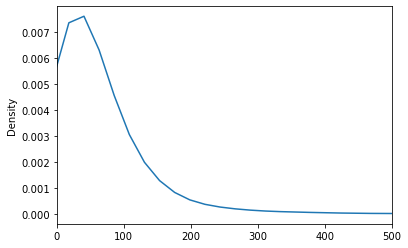

In [52]:
%%local
df_trajets_zurich['delay'].plot(kind='density',x='delay',xlim=[0,500])

#### when taking into account only positive delays, the shape of the density was more or less as an exponential distritbution. (especially when we start from 50seconds)

In [53]:
# Number of stops where the transport type is TRAM
df_trajets_zurich.where('type == "tram"').select('stop_id').distinct().count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1

In [54]:
## we consider TRAM as TRAIN , and we replace Zug with TRAIN:
df_trajets_zurich = df_trajets_zurich.withColumn('type',F.when( (F.col('type')=='zug') | (F.col('type')=='tram'),'train').otherwise(F.col('type')))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [55]:
df_trajets_zurich.select('type','delay').groupBy('type').mean().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----------------+
| type|       avg(delay)|
+-----+-----------------+
|  bus|57.37832457397675|
|train|65.67817170663886|
+-----+-----------------+

#### WE CAN SEE HERE THAT DEPENDING ON WHICH TYPE OF TRANSPORT WE USE, IN AVERAGE THE DELAY VARIES BY ALMOST 10 SECONDS 

In [56]:
df_trajets_zurich.select('stop_name','stop_id','type','delay').groupBy('stop_name','stop_id','type').mean().show()

### 8573205
### 8502273

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-------+-----+------------------+
|           stop_name|stop_id| type|        avg(delay)|
+--------------------+-------+-----+------------------+
|              Horgen|8503204|train| 66.36301369863014|
|Zürich Flughafen,...|8573213|  bus|104.84508196721312|
|Herrliberg-Feldme...|8503103|train| 38.06737588652482|
|          Effretikon|8503305|train| 53.14420485175202|
|Hausen am Albis, ...|8502758|  bus|30.746031746031747|
|          Oberrieden|8503203|train|117.26282051282051|
|   Zürich Altstetten|8503001|train|62.405311778290994|
|Birmensdorf ZH, B...|8573718|  bus| 43.62378640776699|
| Winkel am Zürichsee|8503111|train|110.95390070921985|
|     Horgen, Bahnhof|8503855|  bus|13.387125220458554|
|Zürich Flughafen,...|8573205|  bus|31.915737704918033|
|            Hedingen|8502223|train| 72.17153284671532|
|Zürich Tiefenbrunnen|8503004|train|42.170967741935485|
|  Zürich Wollishofen|8503009|train|108.55483870967743|
|          Glattbrugg|8503310|train| 65.20426829

#### WE CAN SEE HERE THAT APART FROM THE TYPE OF TRANSPORT WE USE, THE AVERAGE DELAY ALSO VARIES A LOT DEPENDING ON THE STOP WE ARE REACHING.

#### We will create 3 categories of time-of-the-day, 4 Hours each :

    - between 07:00 and 11:00 (category : 1)
    - between 11:00 and 15:00 (category : 2)
    - between 15:00 and 19:00 (category : 3)

In [57]:
date = '07.05.2019 '
categories = spark.createDataFrame([(date+'07:00',date+'11:00',date+'15:00',date+'19:00')], ['7H','11H','15H','19H'])
categories=categories.withColumn('7H',F.unix_timestamp('7H',format='dd.MM.yyyy HH:mm'))\
                     .withColumn('11H',F.unix_timestamp('11H',format='dd.MM.yyyy HH:mm'))\
                     .withColumn('15H',F.unix_timestamp('15H',format='dd.MM.yyyy HH:mm'))\
                     .withColumn('19H',F.unix_timestamp('19H',format='dd.MM.yyyy HH:mm'))
categories.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+----------+----------+----------+
|        7H|       11H|       15H|       19H|
+----------+----------+----------+----------+
|1557205200|1557219600|1557234000|1557248400|
+----------+----------+----------+----------+

##### Assign each relation to a category/slot of time

In [58]:
df_trajets_zurich=df_trajets_zurich.withColumn('category',F.when(F.unix_timestamp(df_trajets_zurich.arrival_time,format='dd.MM.yyyy HH:mm').between(1557205200,1557219600),1).otherwise(None))
df_trajets_zurich = df_trajets_zurich.withColumn('category',F.when((F.unix_timestamp(df_trajets_zurich.arrival_time,format='dd.MM.yyyy HH:mm').between(1557219600,1557234000)) | (df_trajets_zurich.category == None) ,2).otherwise(df_trajets_zurich.category))
df_trajets_zurich=df_trajets_zurich.withColumn('category',F.when((F.unix_timestamp(df_trajets_zurich.arrival_time,format='dd.MM.yyyy HH:mm').between(1557234000,1557248400)) | (df_trajets_zurich.category == None) ,3).otherwise(df_trajets_zurich.category))

df_trajets_zurich=df_trajets_zurich.withColumn('category',F.when((F.unix_timestamp(df_trajets_zurich.departure_time,format='dd.MM.yyyy HH:mm').between(1557205200,1557219600)) & (df_trajets_zurich.category == None),1).otherwise(df_trajets_zurich.category))
df_trajets_zurich = df_trajets_zurich.withColumn('category',F.when((F.unix_timestamp(df_trajets_zurich.departure_time,format='dd.MM.yyyy HH:mm').between(1557219600,1557234000)) | (df_trajets_zurich.category == None) ,2).otherwise(df_trajets_zurich.category))
df_trajets_zurich=df_trajets_zurich.withColumn('category',F.when((F.unix_timestamp(df_trajets_zurich.departure_time,format='dd.MM.yyyy HH:mm').between(1557234000,1557248400)) | (df_trajets_zurich.category == None) ,3).otherwise(df_trajets_zurich.category))

df_filtered_trajets_zurich=df_trajets_zurich.filter(df_trajets_zurich.category.isNotNull())
df_filtered_trajets_zurich.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------------+-----+----------------+----------------+-------+-----+--------+
|       stop_name| type|    arrival_time|  departure_time|stop_id|delay|category|
+----------------+-----+----------------+----------------+-------+-----+--------+
|       Zürich HB|train|07.05.2019 07:23|            null|8503000|142.5|       1|
|       Zürich HB|train|07.05.2019 08:23|            null|8503000| 11.0|       1|
|       Zürich HB|train|07.05.2019 10:50|            null|8503000| 22.5|       1|
|       Zürich HB|train|07.05.2019 07:00|            null|8503000| 24.0|       1|
|       Zürich HB|train|07.05.2019 08:26|07.05.2019 08:37|8503000|165.0|       1|
|       Zürich HB|train|07.05.2019 17:53|            null|8503000| -2.0|       3|
|       Zürich HB|train|07.05.2019 12:50|            null|8503000|292.0|       2|
|       Zürich HB|train|07.05.2019 08:10|            null|8503000|-27.5|       1|
|       Zürich HB|train|07.05.2019 17:10|            null|8503000| 24.0|       3|
|       Zürich H

In [59]:
df_filtered_trajets_zurich.select('type','category','delay').groupBy('type','category').mean().sort('type','category').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------+-------------+------------------+
| type|category|avg(category)|        avg(delay)|
+-----+--------+-------------+------------------+
|  bus|       1|          1.0|114.05879292403746|
|  bus|       2|          2.0| 35.73896499238965|
|  bus|       3|          3.0| 69.38258495145631|
|train|       1|          1.0|  76.3078093306288|
|train|       2|          2.0| 57.97915988277434|
|train|       3|          3.0| 79.04225786551511|
+-----+--------+-------------+------------------+

#### We can clearly see the effect of the category of the chosen time of travel, especially when choosing the BUS

In [60]:
df_filtered_trajets_zurich.select('type','category','stop_id','delay').groupBy('type','category','stop_id').mean().drop('avg(category)').sort('stop_id').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------+-------+------------------+
| type|category|stop_id|        avg(delay)|
+-----+--------+-------+------------------+
|train|       1|8502186|        104.328125|
|train|       2|8502186|              96.0|
|train|       3|8502186|           175.125|
|train|       2|8502187|         59.203125|
|train|       3|8502187|        137.390625|
|train|       1|8502187|          64.90625|
|train|       2|8502188|         81.734375|
|train|       3|8502188|171.53030303030303|
|train|       1|8502188|         78.515625|
|train|       1|8502208|          48.03125|
|train|       2|8502208|          61.53125|
|train|       3|8502208|          35.09375|
|train|       2|8502209|         118.90625|
|train|       3|8502209|          89.84375|
|train|       1|8502209|          104.0625|
|train|       2|8502220|         62.296875|
|train|       1|8502220|         86.046875|
|train|       3|8502220|         100.21875|
|train|       1|8502221|         15.765625|
|train|       3|8502221|        

#### Finally, we will group our delays data depending on the type of transport (type), the category/slot of time (category) and the 'stop_id' in question. We will also compute the Mean of each same partition that will be used to perform the paramater estimation of our exponential distribution. We will also keep the maximum delay of each partition: that way, in a change, with difference {diff = next departure time - actual arrival time} : if diff>max(delay) then the probability of reaching our next relation is 1

In [61]:
df_delays=df_filtered_trajets_zurich.select('type','category','stop_id','delay').groupBy('type','category','stop_id').agg(F.avg('delay'),F.max('delay')).sort('stop_id')
df_delays.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+--------+-------+------------------+----------+
| type|category|stop_id|        avg(delay)|max(delay)|
+-----+--------+-------+------------------+----------+
|train|       2|8502186|              96.0|     152.0|
|train|       3|8502186|           175.125|     374.5|
|train|       1|8502186|        104.328125|     182.5|
|train|       1|8502187|          64.90625|     167.0|
|train|       2|8502187|         59.203125|     129.0|
|train|       3|8502187|        137.390625|     305.0|
|train|       1|8502188|         78.515625|     228.5|
|train|       2|8502188|         81.734375|     162.5|
|train|       3|8502188|171.53030303030303|     327.5|
|train|       1|8502208|          48.03125|     125.0|
|train|       3|8502208|          35.09375|      76.0|
|train|       2|8502208|          61.53125|     168.0|
|train|       1|8502209|          104.0625|     205.5|
|train|       2|8502209|         118.90625|     261.0|
|train|       3|8502209|          89.84375|     163.5|
|train|   

In [96]:
# This function will be used to filter our data to get only relations in a range of 2 hours before the specified arrival time
def filter_data(arrival_time):
    i,j = arrival_time.split(':')
    time_minus_2hours = str(int(i)-2)+':'+j
    filtered_data = final_df.filter((final_df.arrival.between(time_minus_2hours,arrival_time)) | (final_df.type=='walking'))
    return filtered_data

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## VALIDATION

In [98]:
@F.udf
def to_seconds(string):
    string = string[:5]
    i,j = string.split(':')
    seconds = int(i)*60*60 + int(j)*60
    return seconds

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [101]:
filtered_data = filter_data("12:00")
filtered_data = filtered_data.withColumn('departure',to_seconds(filtered_data.departure)).withColumn('arrival',to_seconds(filtered_data.arrival)).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

10:00
+-------+--------------------+---------+--------------+-------+-------+--------------------+------------+-------------+-----+-------------+
| source|             trip_id|departure|from_stop_name|arrival| target|        to_stop_name|direction_id|     route_id| type|walk_duration|
+-------+--------------------+---------+--------------+-------+-------+--------------------+------------+-------------+-----+-------------+
|8503303|103.TA.26-3-j19-1...|    36120|        Illnau|  36480|8503305|          Effretikon|           0|   26-3-j19-1|train|         null|
|8503303|106.TA.26-3-j19-1...|    39720|        Illnau|  40080|8503305|          Effretikon|           0|   26-3-j19-1|train|         null|
|8503303|31.TA.26-3-j19-1.6.H|    41520|        Illnau|  41880|8503305|          Effretikon|           0|   26-3-j19-1|train|         null|
|8503303|28.TA.26-3-j19-1.8.H|    36120|        Illnau|  36480|8503305|          Effretikon|           0|   26-3-j19-1|train|         null|
|8503303|107.T

In [65]:
sources = final_df.select("source").distinct().withColumnRenamed('source', 'node')
targets = final_df.select("target").distinct().withColumnRenamed('target', 'node')

both = sources.union(targets).distinct()

relevant_nodes = df_stops_zurich.join(both, df_stops_zurich.stop_id == both.node, 'inner')\
    .select(['stop_id', 'stop_lat', 'stop_lon', 'stop_name2'])\
    .withColumnRenamed('stop_lat', 'latitude')\
    .withColumnRenamed('stop_lon', 'longitude')\
    .withColumnRenamed('stop_name2', 'stop_name')


relevant_nodes.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+---------+--------------------+
|stop_id| latitude|longitude|           stop_name|
+-------+---------+---------+--------------------+
|8503088|47.377434| 8.539169|       Zürich HB SZU|
|8503303| 47.40882| 8.722704|              Illnau|
|8503855|47.261612| 8.595674|     Horgen, Bahnhof|
|8502276|47.362175| 8.366792|       Berikon-Widen|
|8503203|47.279675| 8.578453|          Oberrieden|
|8502224|47.276066|  8.44658|  Affoltern am Albis|
|8587020|47.405834| 8.404521|   Dietikon, Bahnhof|
|8503004|47.350124| 8.561376|Zürich Tiefenbrunnen|
|8502208|47.258747| 8.589799|     Horgen Oberdorf|
|8503008| 47.42091| 8.508564|    Zürich Affoltern|
|8503104|47.269814|  8.64429|              Meilen|
|8517377| 47.35379| 8.350272|  Bibenlos-Sonnenhof|
|8502221|47.357433| 8.437543|      Birmensdorf ZH|
|8503304|47.452835| 8.705573|           Kemptthal|
|8573205| 47.45016| 8.563747|Zürich Flughafen,...|
|8503508| 47.40578|  8.40497|            Dietikon|
|8503020|47.385197| 8.517107|  

In [66]:
walk_edges = filtered_data.where('type="walking"').select('source','target','walk_duration')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
## EACH ROUTE_ID has its unique transport type ! 
route_type = filtered_data.select('route_id','type').distinct()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [102]:
%%spark -o relevant_nodes -n -1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [103]:
%%spark -o filtered_data -n -1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
'NoneType' object has no attribute 'toJSON'
Traceback (most recent call last):
AttributeError: 'NoneType' object has no attribute 'toJSON'



In [104]:
%%spark -o route_type -n -1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [105]:
%%spark -o walk_edges -n -1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [106]:
%%spark -o df_delays -n -1

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [107]:
%%local
import pandas as pd
import networkx as nx

df = pd.DataFrame(filtered_data)
route_types = pd.DataFrame(route_type)

In [108]:
%%local
Graph = nx.convert_matrix.from_pandas_edgelist(df,source='source',target='target',edge_attr=True, create_using=nx.MultiDiGraph())

nodes_attributes = relevant_nodes.set_index('stop_id').to_dict('index')
nx.set_node_attributes(Graph, nodes_attributes)

import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from heapq import heappush, heappop
from itertools import count

from fastest_paths_algorithm import get_shortest_paths_DFs

#s = 8503202
#t = 8503103

s= 8503104
t= 8503508

#s = 8503006
#t = 8503311
path_gen, paths_df, paths_edges_df, summary_df = get_shortest_paths_DFs(Graph, s, t)

132


In [109]:
%%local
summary_df

Output()

In [110]:
relevant_nodes[relevant_nodes.stop_id==8503202]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

DataFrame[stop_id: string, latitude: float, longitude: float, stop_name: string]

In [111]:
%%local
import datetime
import numpy as np
summary_df["departure"] = summary_df.departure.apply(lambda col: str(pd.Timestamp(col,unit='s'))[11:16])
summary_df["arrival"] = summary_df.arrival.apply(lambda col: str(pd.Timestamp(col,unit='s'))[11:16])

In [112]:
%%local
def categorize(time):
    if time=='': return None
    if time>= '07:00' and time<'11:00' : return 1
    elif time>='11:00' and time<'15:00': return 2
    else: return 3
summary_df['category'] = summary_df.apply(lambda row: categorize(row.arrival) ,axis=1)

In [113]:
%%local
import numpy
## add walking duration
def add_seconds(string,seconds):
    sec = int(seconds)
    i,j = string.split(':')
    min_from_sec = int(sec/60)
    remaining_seconds = sec - (min_from_sec*60)
    minute= str(int(i)+min_from_sec)
    seconds=str(int(j)+remaining_seconds)
    return minute+':'+seconds

def to_seconds(string):
    i,j = string.split(':')
    seconds = int(i)*60*60 + int(j)*60
    return seconds

def difference_in_seconds(prev_arrival,departure):
    t1 = to_seconds(prev_arrival)
    t2 = to_seconds(departure)
    return t2-t1
    

def get_avg_max(type_, category, stop):
    avg,max_=df_delays.where((df_delays.type==type_)&(df_delays.category==category)&(df_delays.stop_id==stop)).dropna()[['avg(delay)','max(delay)']].values[0]
    return avg,max_

def compute_proba_exp(lambda_ , x):
    return 1 - np.exp(-lambda_*x)

def print_results(df):
    path_i = 0
    print('These are all the possible paths :')
    print(100*'=')
    print(100*'=')
    print(f'path {path_i+1}')
    print(100*'=')
    departure_time = '12:00'
    walking_departure = departure_time ##input_time
    probabilities = []
    first_travel = True
    for row in df.iterrows():
        path_id = row[1].path_id
        if path_id !=path_i:
            print(f'This path has a probability {np.prod(probabilities)} of success')
            print(100*'=')
            print(100*'=')
            print(f"path {path_id+1}")
            print(100*'=')
            path_i = path_id
            walking_departure = departure_time ##input_time
            probabilities = []
            first_travel = True


        if ((row[1].type=='train') or (row[1].type=='bus')):
            s = row[1].source
            t = row[1].target
            type_ = row[1].type
            dep = row[1].departure
            arr = row[1].arrival
            cat = row[1].category

            ## dealing with delay
            if first_travel==True : 
                proba = 1
                previous_arrival = arr
                first_travel= False
            else:
                avg_delay,max_delay = get_avg_max(type_,cat,t)
                time_to_change = difference_in_seconds(previous_arrival,dep)
                if (time_to_change>max_delay):
                    proba=1
                else:
                    proba = compute_proba_exp(lambda_ = 1/avg_delay , x=time_to_change)
                previous_arrival = arr


            next_type = row[1].type_next
            if(next_type=='walking'): walking_departure = arr
            print(f'Take the {type_} at {dep} from {s} to {t}')
            print(f"You'll get there at {arr} with probability {proba}")
            probabilities.append(proba)

        else:
            s = row[1].source
            t = row[1].target
            dep = walking_departure
            duration = row[1].duration
            arr = add_seconds(dep,duration)

            ## dealing with delay
            if first_travel==True : 
                previous_arrival = arr
                first_travel=False


            proba=1
            next_type = row[1].type_next
            if(next_type=='walking'): walking_departure = arr
            print(f'Now, walk from {s} to {t}')
            print(f"You'll get there at {arr} with probability {proba}")
            probabilities.append(proba)


        print(100*'=')

    print(f'This path has a probability {np.prod(probabilities)} of success')
    print(100*'=')
    print(100*'=')

In [114]:
%%local
print_results(summary_df)

These are all the possible paths :
path 1
Take the train at 09:32 from 8503104 to 8503000
You'll get there at 09:47 with probability 1
Take the train at 09:48 from 8503000 to 8503001
You'll get there at 09:54 with probability 0.5811512026606878
Take the train at 10:05 from 8503001 to 8503508
You'll get there at 10:14 with probability 1
This path has a probability 0.5811512026606878 of success
path 2
Take the train at 09:32 from 8503104 to 8503000
You'll get there at 09:47 with probability 1
Take the train at 09:48 from 8503000 to 8503001
You'll get there at 09:54 with probability 0.5811512026606878
Take the train at 10:15 from 8503001 to 8503508
You'll get there at 10:21 with probability 1
This path has a probability 0.5811512026606878 of success
path 3
Take the train at 09:32 from 8503104 to 8503000
You'll get there at 09:47 with probability 1
Take the train at 09:48 from 8503000 to 8503001
You'll get there at 09:54 with probability 0.5811512026606878
Take the train at 10:16 from 8503

In [81]:
relevant_nodes.filter(relevant_nodes.stop_name=='Meilen').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+---------+---------+
|stop_id| latitude|longitude|stop_name|
+-------+---------+---------+---------+
|8503104|47.269814|  8.64429|   Meilen|
+-------+---------+---------+---------+

## Visualizing paths

In [85]:
%%local
def extract_nodes_infos(G, path_df):
    first_node = G.nodes[path_df.iloc[0]['source']]
    
    lon_array, lat_array = [first_node['longitude']], [first_node['latitude']]
    stop_names = [first_node['stop_name']]
    
    for idx, edge_row in path_df.iterrows():
        node = G.nodes[edge_row['target']]
        
        lon_array.append(node['longitude'])
        lat_array.append(node['latitude'])
        stop_names.append(node['stop_name'])
        
        
    return lon_array, lat_array, stop_names

In [86]:
%%local
paths_df

Output()

In [87]:
%%local
import plotly.graph_objects as go

def visualize_paths(G, paths_df, paths_edges_df, s, t):
    fig = go.Figure()

    COLORS = [
        "#8260c9",
        "#77b341",
        "#cb57b3",
        "#51a671",
        "#d44360",
        "#4ac0cd",
        "#cd5a2b",
        "#7085ca",
        "#cca242",
        "#ba658c",
        "#7a7a32",
        "#c6795c"
    ]


    COLOR_MAP = {
        idx: COLORS[idx % len(COLORS)] 
        for idx, _ in enumerate(pd.Series.drop_duplicates(paths_df['ta_path_id']).values)
    }

    edge_x = []
    edge_y = []
    for edge in G.edges():
        x0, y0 = G.nodes[edge[0]]['longitude'], G.nodes[edge[0]]['latitude']
        x1, y1 = G.nodes[edge[1]]['longitude'], G.nodes[edge[1]]['latitude']
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    edge_trace = go.Scattermapbox(
        mode = "markers+lines",
        lon=edge_x, 
        lat=edge_y,
        line=dict(width=0.5, color='#888'),
        marker={'size': 5},
        name='Others',
        showlegend = False,
        hoverinfo='none'
        )

    fig.add_trace(edge_trace)


    for idx, path_row in paths_df.iterrows():

        path_df = paths_edges_df[paths_edges_df['path_id'] == path_row['path_id']]

        lon_array, lat_array, stop_names = extract_nodes_infos(G, path_df)    

        fig.add_trace(go.Scattermapbox(
            mode = "markers+lines",
            lon = lon_array,
            lat = lat_array,
            name = f"Path {idx + 1}",
            customdata = stop_names,
            marker = {
                'size': 10,
                'color': COLOR_MAP[path_row['ta_path_id']],
            },
            line = {
                'color': COLOR_MAP[path_row['ta_path_id']]
            },
            hovertemplate =
                '<b>Station name</b>: %{customdata}'+
                '<br><b>Longitude</b>: %{lon}'+
                '<br><b>Latitude</b>: %{lat}',
            legendgroup = path_row['ta_path_id']
        ))


    fig.update_layout(
        margin ={'l':0,'t':0,'b':0,'r':0},
        mapbox = {
            'center': {'lon': 8.540192, 'lat': 47.378177},
            'style': "carto-positron",
            'center': {'lon': 8.540192, 'lat': 47.378177},
            'zoom': 10},
        legend = {
            'itemclick': 'toggleothers'
        },
        height= 600
        )

    fig.show()

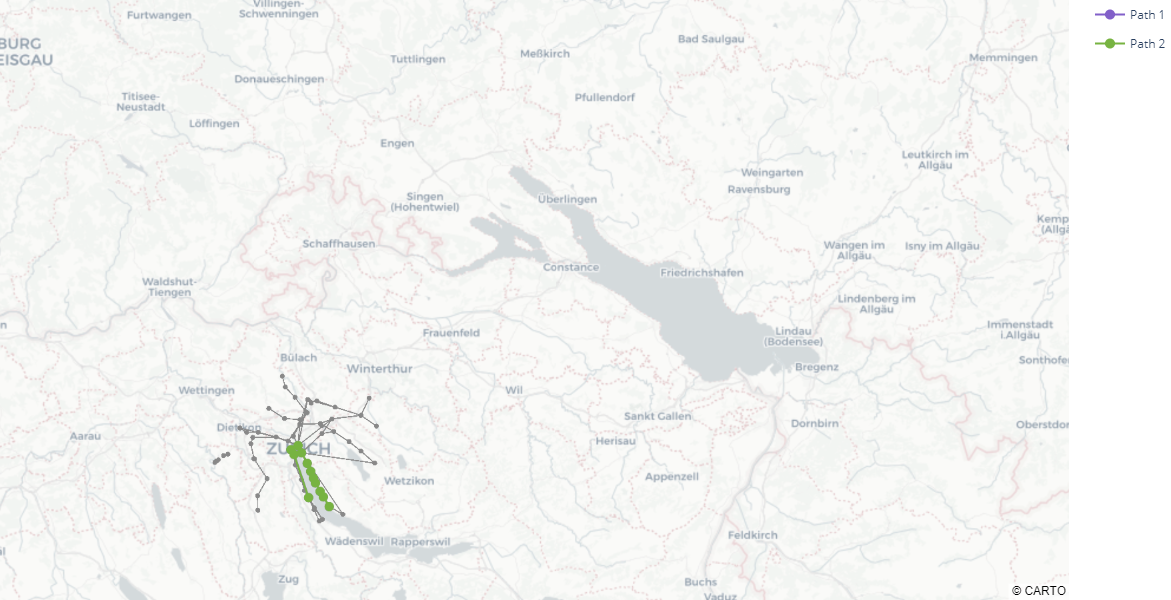

In [88]:
%%local
visualize_paths(Graph, paths_df, paths_edges_df, s, t)

In [89]:
%%local
## Function to be called from ipywidget
## Needs to be modular, needs to call modular functions
## def run_all(s, t, arrival_time, confidence):
    ## CALL APPROPRIATE FUNCTION THAT QUERIES THE DATA TABLES AND CONSTRUCT APPROPRIATE GRAPH GIVEN ARRIVAL_TIME
    # G = ....
    
    ## CALL APPROPRIATE FUNCTION THAT COMPUTES ALL SHORTEST PATHS
    # path_gen, paths_df, paths_edges_df, summary_df = get_shortest_paths_DFs(Graph, s, t)
    
    ## CALL APPROPRIATE FUNCTION THAT ADDS RISK TO SUMMARY_DF AND PATHS_DF
    ## BEUATIFY SUMMARY_DF (stop_names instead of stop_ids, delete not needed columns, human readable times, human readable directions, line number instead of route id)
    # paths_df = 
    # summary_df = 
    
    ## VISUALIZE THE MAP
    # visualize_paths(Graph, paths_df, paths_edges_df, s, t)
    

In [90]:
%%local
import ipywidgets as widgets

form_item_layout = widgets.Layout(
    display='flex',
    flex_flow='row',
    justify_content='space-between',
    
)

arrival_hour = widgets.BoundedIntText( min = 8, max = 16, step = 1, disabled = False,\
                                    layout = form_item_layout)
arrival_minute = widgets.BoundedIntText(value = 30,min = 0,max = 59, step = 1, disabled = False, layout =form_item_layout)

start_stop = widgets.Dropdown(options=relevant_nodes['stop_name'], layout=form_item_layout)

end_stop =  widgets.Dropdown(options=relevant_nodes["stop_name"], layout=form_item_layout)

valid = widgets.Button(description='Search', disabled=False, button_style='primary',tooltip='Go ahead and click',icon='search')

out = widgets.Output()

hbox1 = widgets.HBox([widgets.Label(value="From:", layout=form_item_layout),start_stop,widgets.Label(value="To:", layout=form_item_layout), end_stop])
hbox2 = widgets.HBox([widgets.Label(value="Arrives at:",), arrival_hour, arrival_minute])

ui = widgets.VBox([ hbox1, hbox2])
display(ui, out)

Output()

In [101]:
#Save all needed dataframes : 

final_df.write.parquet('/user/{0}/final_df.parquet'.format(username))

relevant_nodes.write.parquet('/user/{0}/relevant_nodes.parquet'.format(username))

route_type.write.parquet('/user/{0}/route_type.parquet'.format(username))

walk_edges.write.parquet('/user/{0}/walk_edges.parquet'.format(username))

df_delays=df_delays.withColumnRenamed("avg(delay)",'avg').withColumnRenamed("max(delay)",'max')
df_delays.write.parquet('/user/{0}/df_delays.parquet'.format(username))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [105]:
relevant_nodes.write.parquet('/user/{0}/relevant_nodes.parquet'.format(username))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## NOW WE CAN DO EVERYTHING IN ANOTHER NOTEBOOK (IN LOCAL)